In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver

from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        coeff = 0.38 if len(self.shape) == 3 else 0.42
        return .1*self.spacing[0]

# Source function

The source time function is a Ricker Wavelet with peak frequency $f_0$ defined as:

\begin{equation}
     s(t) = (1 - 2 (\pi f_0 (t - \frac{2}{f_0}))^2) \text{exp}(-(\pi f_0 (t - \frac{2}{f_0}))^2)
\end{equation}

In [3]:
def source(time, f0):
    r = (np.pi * f0 * (time - 1./f0))
    src = (1-2.*r**2)*np.exp(-r**2)
    return np.float32(src)

# Analytical solution

In 2D case, the Green's function is

$$
G = \frac{1}{2\pi c^2}\frac{H(t-\frac{|r|}{c})}{\sqrt{t^2-\frac{r^2}{c^2}}}
$$

$$
r = \sqrt{x^2+y^2}
$$

where $H$ is the Heaviside function, defined as 

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

and for a given time signature, the analytical solution is given by the convolution of the Green's function and the source time signature.

In [4]:
def G(time, source, r, dtloc):
    nt = len(time)
    G = np.zeros((nt, len(r)), dtype=np.float32)
    v = np.float32(1.0)
    for ix in range(len(r)):
        Gc = time * 0.
        for it in range(0, nt): # Calculate Green's function
            if ((time[it] - r[ix] / v) > 1e-5):
                Gc[it] = (1. / (2 * np.pi)) \
                         * (1. / np.sqrt((time[it] ** 2) - ((r[ix]/v) ** 2)))
        G[:, ix]   = np.convolve(Gc, source * dtloc).astype(np.float32)[0:nt]
    return G

# Verification

We compute the error between the numerical and analytical solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the erro for these parameters.

In [6]:
from sympy import Eq, solve
from devito import clear_cache, Operator, TimeFunction
from devito.logger import set_log_level
sizes = ((401 , 2.0), (301, 3.0), (201, 4.0), (101, 5.0), (51, 6.0))
orders = [2, 4, 6, 8 ,10]

errorl2 = np.zeros((len(sizes), len(orders)))
times = np.zeros((len(sizes), len(orders)))

set_log_level("ERROR")

cs = -1

for nn, h in sizes:
    cs += 1
    co = -1
#     print("starting dx=%s with (%s, %s) grid points" % (h, nn, nn))
    for spc in orders:
#         print("starting space order %s with (%s, %s) grid points" % (spc, nn, nn))
        co += 1
        clear_cache()
        modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc)
        dt = modelloc.critical_dt
        t0 = 0.0
        nt = int(200.0/dt)  # Number of timesteps
        time1 = np.asarray([i*dt for i in range(nt)]).astype(np.float32) # Discretized time axis
        src = PointSource(name='src', grid=modelloc.grid, ntime=nt, npoint=1)
        src.coordinates.data[0, :] = np.array(modelloc.domain_size) * .5
        src.data[:, 0] = source(time1, 0.015)
        
        sx = int((nn-1)/2)
        
        rloc = h*np.abs(np.arange(-sx, sx+1), dtype=np.float32)
            
        analyticalloc = G(time1, source(time1, 0.015), rloc, dt)

        # Create symbols for forward wavefield, source and receivers
        u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                         time_order=2, space_order=spc)

        eqn = modelloc.m * u.dt2 - u.laplace
        s = modelloc.grid.stepping_dim.spacing
        stencil = [Eq(u.forward, 2.0 * u - u.backward + s**2/modelloc.m * u.laplace)]

        # Construct expression to inject source values
        src_term = [Eq(u.indexed[modelloc.grid.stepping_dim + 1, sx+spc, sx+spc],
                       u.indexed[modelloc.grid.stepping_dim + 1, sx+spc, sx+spc]+
                       src.indexed[modelloc.grid.time_dim, src.indices[1]])]
        # Substitute spacing terms to reduce flops
        subs = dict({u.indices[0].spacing: dt}, **modelloc.spacing_map)

        op = Operator(stencil + src_term, subs=subs, dse='noop', dle='noop')
        
        summary = op.apply ()
            
        errorl2[cs, co] = np.linalg.norm(analyticalloc[nt-1, :]/np.linalg.norm(analyticalloc[nt-1, :]) -
                                         u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]/np.linalg.norm(u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]))
        times[cs, co] = summary.timings['main']
        
        print("starting space order %s with (%s, %s) grid points the error is %s" % (spc, nn, nn, errorl2[cs, co]))
        
        
        

starting space order 2 with (401, 401) grid points the error is 0.0388298146427
starting space order 4 with (401, 401) grid points the error is 0.0500625818968
starting space order 6 with (401, 401) grid points the error is 0.0502969734371
starting space order 8 with (401, 401) grid points the error is 0.0502685420215
starting space order 10 with (401, 401) grid points the error is 0.0502942204475
starting space order 2 with (301, 301) grid points the error is 0.0581800192595
starting space order 4 with (301, 301) grid points the error is 0.0533524788916
starting space order 6 with (301, 301) grid points the error is 0.0540057718754
starting space order 8 with (301, 301) grid points the error is 0.0540395751595
starting space order 10 with (301, 301) grid points the error is 0.0540408566594
starting space order 2 with (201, 201) grid points the error is 0.106561891735
starting space order 4 with (201, 201) grid points the error is 0.0536418259144
starting space order 6 with (201, 201) 

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, len(orders)):
        plot.add_line(list(errorl2[:, i]), list(times[:, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

In [ ]:
print(times)

In [ ]:
print(errorl2)

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6, 8, 10]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc for _, sc in sizes][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])
#         plot.add_line([sc for _, sc in sizes][::-1], list(theory), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

In [37]:
h = 6.0
nn = 51
spc = 10
from devito import clear_cache, TimeFunction, Operator
from sympy import Eq, solve
clear_cache()
modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc)
dt = modelloc.critical_dt
t0 = 0.0
nt = int(150./dt)  # Number of timesteps
time1 = np.asarray([i*dt for i in range(nt)]) # Discretized time axis
src = PointSource(name='src', grid=modelloc.grid, ntime=nt, npoint=1)
src.coordinates.data[0, :] = np.array(modelloc.domain_size) * .5
src.data[:, 0] = source(time1, 0.020)
sx = int((nn-1)/2)

rloc = h*np.abs(np.arange(-sx, sx+1))

analyticalloc = G(time1, source(time1, 0.020), rloc, dt)

# Create symbols for forward wavefield, source and receivers
u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                 time_order=2, space_order=spc)

eqn = modelloc.m * u.dt2 - u.laplace
s = modelloc.grid.stepping_dim.spacing
stencil = [Eq(u.forward, 2.0 * u - u.backward + s**2/modelloc.m * u.laplace)]

# Construct expression to inject source values
src_term = [Eq(u.indexed[modelloc.grid.stepping_dim + 1, sx+spc, sx+spc], 
               u.indexed[modelloc.grid.stepping_dim + 1, sx+spc, sx+spc]+
               src.indexed[modelloc.grid.time_dim, src.indices[1]])]
# Substitute spacing terms to reduce flops
subs = dict({u.indices[0].spacing: dt}, **modelloc.spacing_map)

op = Operator(stencil + src_term, subs=subs, dse='noop', dle='noop')

summary = op.apply ()

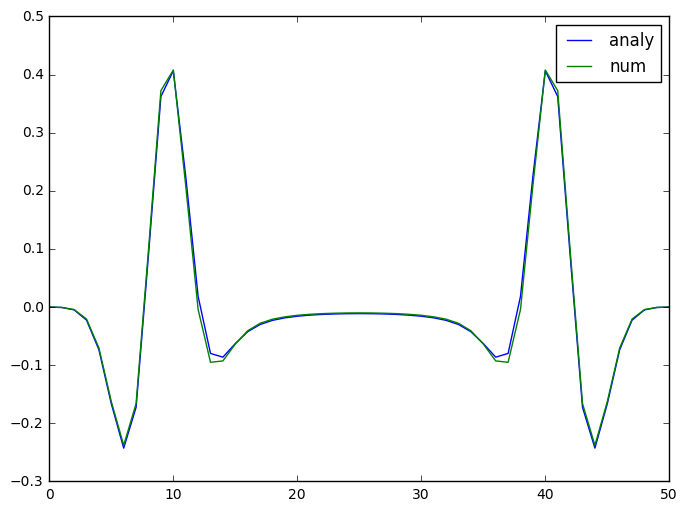

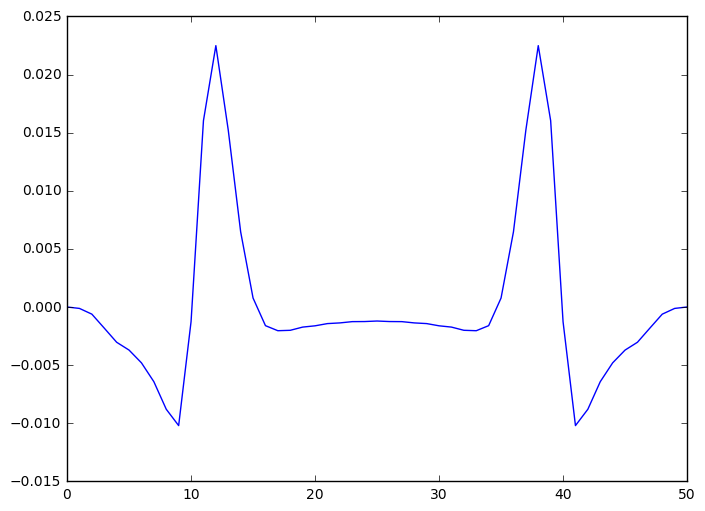

In [38]:
plt.figure()
plt.plot(analyticalloc[nt-1, :]/np.linalg.norm(analyticalloc[nt-1, :], 2), label="analy")
plt.plot(u.data[(nt)%3, spc:-spc, int((nn-1)/2)+spc]/np.linalg.norm(u.data[(nt)%3, spc:-spc, int((nn-1)/2)+spc], 2), label="num")
plt.legend()
plt.show()
plt.figure()
plt.plot(analyticalloc[nt-1, :]/np.linalg.norm(analyticalloc[nt-1, :]) -
         u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]/np.linalg.norm(u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]))
plt.show() 

In [39]:
np.linalg.norm(analyticalloc[nt-1, :]/np.linalg.norm(analyticalloc[nt-1, :]) -
                                         u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]/np.linalg.norm(u.data[nt%3, spc:-spc, int((nn-1)/2)+spc]))

0.051664602